# Consider age and gender recognition simultaneously to take advantage of the gender-specific age characteristics and age-specific gender characteristics inherent to images

## 1. Merge Feature

## 2. Merge Output

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import pylab as pl
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import KFold

import cv2
import random
from PIL import Image
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import EfficientNetB5
from tensorflow.keras import optimizers
from tensorflow import keras

import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
print(tf.__version__)

/mnt/local/yuxin/anaconda3/envs/gender/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2022-11-11 10:50:33.469688: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


2.4.1


In [2]:
from tensorflow.python.client import device_lib
physical_devices = tf.config.list_physical_devices('GPU')

2022-11-11 10:50:35.326891: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-11 10:50:35.327844: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-11 10:50:35.415851: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 10:50:35.416460: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-11-11 10:50:35.416544: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node ze

# Preprocess Adience Dataset

In [3]:
# load data
ADIENCE_PATH = './Adience'
print(os.listdir(path=ADIENCE_PATH))

all_folds={}
for i in range(5):
    all_folds[i]=pd.read_csv(os.path.join(ADIENCE_PATH, f'fold_{i}_data.txt'),sep = "\t" )

['AdienceBenchmarkGenderAndAgeClassification', 'faces', 'fold_0_data.txt', 'fold_1_data.txt', 'fold_2_data.txt', 'fold_3_data.txt', 'fold_4_data.txt', '__MACOSX']


In [4]:
total_data = pd.concat([all_folds[i] for i in range(5)],ignore_index=True)
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             19370 non-null  object
 1   original_image      19370 non-null  object
 2   face_id             19370 non-null  int64 
 3   age                 19370 non-null  object
 4   gender              18591 non-null  object
 5   x                   19370 non-null  int64 
 6   y                   19370 non-null  int64 
 7   dx                  19370 non-null  int64 
 8   dy                  19370 non-null  int64 
 9   tilt_ang            19370 non-null  int64 
 10  fiducial_yaw_angle  19370 non-null  int64 
 11  fiducial_score      19370 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.8+ MB


In [5]:
total_data.head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34


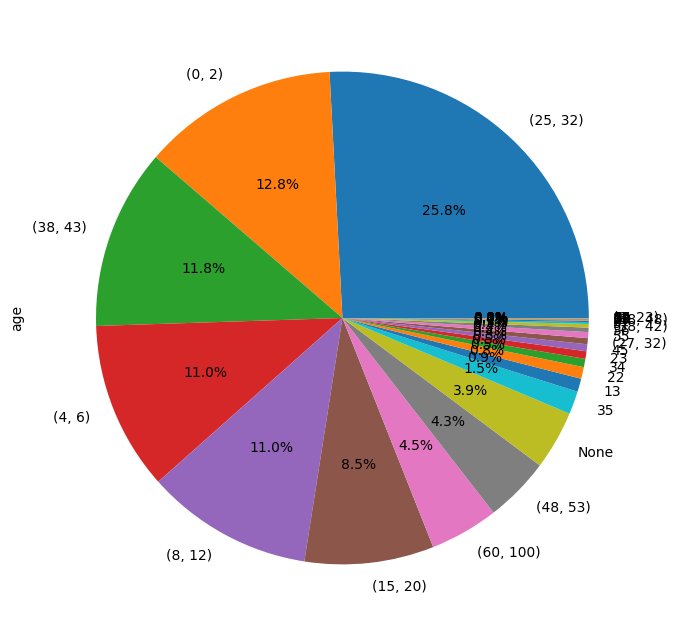

In [6]:
# pie_graph
plt.figure(1, figsize=(8,8))
total_data.age.value_counts().plot.pie(autopct="%1.1f%%")
plt.show()

f    9372
m    8120
u    1099
Name: gender, dtype: int64


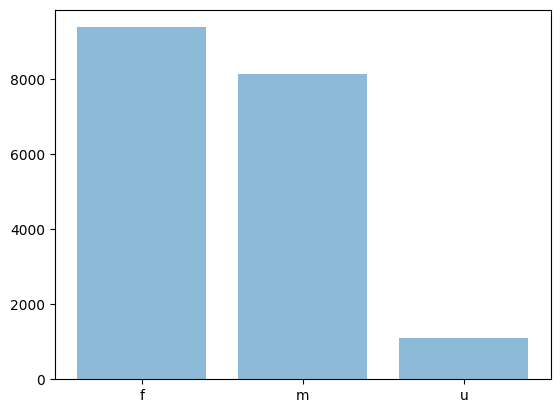

In [7]:
# bar chart
gender = ['f','m','u']
plt.bar(gender, total_data.gender.value_counts(), align='center', alpha=0.5)
print(total_data.gender.value_counts())
plt.show()

In [8]:
df = total_data[['age', 'gender', 'x', 'y', 'dx', 'dy']].copy()

img_path = []

for row in total_data.iterrows():
    path = f"{ADIENCE_PATH}/faces/"+row[1].user_id+"/coarse_tilt_aligned_face."+str(row[1].face_id)+"."+row[1].original_image
    img_path.append(path)
df['img_path'] = img_path

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       19370 non-null  object
 1   gender    18591 non-null  object
 2   x         19370 non-null  int64 
 3   y         19370 non-null  int64 
 4   dx        19370 non-null  int64 
 5   dy        19370 non-null  int64 
 6   img_path  19370 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.0+ MB


In [9]:
age_mapping = [('(0, 2)', '0-2'), ('2', '0-2'), ('3', '0-2'), ('(4, 6)', '4-6'), ('(8, 12)', '8-13'), ('13', '8-13'), ('22', '15-20'), ('(8, 23)','15-20'), ('23', '25-32'), ('(15, 20)', '15-20'), ('(25, 32)', '25-32'), ('(27, 32)', '25-32'), ('32', '25-32'), ('34', '25-32'), ('29', '25-32'), ('(38, 42)', '38-43'), ('35', '38-43'), ('36', '38-43'), ('42', '48-53'), ('45', '38-43'), ('(38, 43)', '38-43'), ('(38, 42)', '38-43'), ('(38, 48)', '48-53'), ('46', '48-53'), ('(48, 53)', '48-53'), ('55', '48-53'), ('56', '48-53'), ('(60, 100)', '60+'), ('57', '60+'), ('58', '60+')]

age_mapping_dict = {each[0]: each[1] for each in age_mapping}
drop_labels = []
for idx, each in enumerate(df.age):
    if each == 'None':
        drop_labels.append(idx)
    else:
        df.age.loc[idx] = age_mapping_dict[each]

df = df.drop(labels=drop_labels, axis=0) #droped None values
df.age.value_counts(dropna=False)

/tmp/ipykernel_22446/3604610946.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = age_mapping_dict[each]


25-32    5296
38-43    2776
0-2      2509
8-13     2292
4-6      2140
15-20    1792
48-53     916
60+       901
Name: age, dtype: int64

In [10]:
df = df.dropna()
unbiased_data = df[df.gender != 'u'].copy()
unbiased_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17452 entries, 0 to 19345
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       17452 non-null  object
 1   gender    17452 non-null  object
 2   x         17452 non-null  int64 
 3   y         17452 non-null  int64 
 4   dx        17452 non-null  int64 
 5   dy        17452 non-null  int64 
 6   img_path  17452 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.1+ MB


In [11]:
gender_to_label_map = {
    'f' : 0,
    'm' : 1
}

age_to_label_map = {
    '0-2'  :0,
    '4-6'  :1,
    '8-13' :2,
    '15-20':3,
    '25-32':4,
    '38-43':5,
    '48-53':6,
    '60+'  :7
}

# label_to_age_map = {value: key for key, value in age_to_label_map.items()}
# label_to_gender_map = {value: key for key, value in gender_to_label_map.items()}

unbiased_data['age'] = unbiased_data['age'].apply(lambda age: age_to_label_map[age])
unbiased_data['gender'] = unbiased_data['gender'].apply(lambda g: gender_to_label_map[g])

unbiased_data.head()

,age,gender,x,y,dx,dy,img_path
0,4,0,0,414,1086,1383,./Adience/faces/30601258@N03/coarse_tilt_align...
1,4,1,301,105,640,641,./Adience/faces/30601258@N03/coarse_tilt_align...
2,4,0,2395,876,771,771,./Adience/faces/30601258@N03/coarse_tilt_align...
3,4,1,752,1255,484,485,./Adience/faces/30601258@N03/coarse_tilt_align...
4,4,1,175,80,769,768,./Adience/faces/30601258@N03/coarse_tilt_align...


# Create Dataset

In [13]:
X = unbiased_data[['img_path']]
if merge_age:
    y = unbiased_data[['gender','age']]
else:
    y = unbiased_data[['gender']]


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Train data shape {}'.format(X_train.shape))
print('Test data shape {}'.format(X_test.shape))
print('Train data shape {}'.format(y_train.shape))
print('Test data shape {}'.format(y_test.shape))

Train data shape (12216, 1)
Test data shape (5236, 1)
Train data shape (12216, 2)
Test data shape (5236, 2)


In [14]:
train_images = []
test_images = []

for row in X_train.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((227, 227))   # Resize the image
    data = np.asarray(image)
    train_images.append(data)

for row in X_test.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((227, 227))  # Resize the image
    data = np.asarray(image)
    test_images.append(data)

train_images = np.asarray(train_images)
test_images = np.asarray(test_images)

print('Train images shape {}'.format(train_images.shape))
print('Test images shape {}'.format(test_images.shape))

Train images shape (12216, 227, 227, 3)
Test images shape (5236, 227, 227, 3)


# Create Model
---
## Hyperparameters

In [15]:
batch_size = 32
epochs = 20
target_size = (227, 227) # (64, 64)
input_shape = (227, 227, 3) #(64, 64, 3)

# random seed
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

adam = 0.001
fre = -20
FC = 2048
E = 1
patience = 5
verbose = 1
factor = 0.50
min_lr = 0.0001
steps_per_epoch = 256
validation_steps = 256

drop_out_rate = 0.5

In [16]:
# init your model here before complilation
model = EfficientNetB5(weights='imagenet',
                        include_top=False,
                        input_shape=input_shape)

# input (1, 227, 227, 3) -> output (1, 5, 5, 2048)

2022-11-11 10:52:58.187809: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-11 10:52:58.188099: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-11 10:52:58.351735: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 10:52:58.352047: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/

In [17]:
# visualize your model

from tensorflow.keras.utils import plot_model

model.summary()
plot_model(model, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)
# plot_model(model)

Model: "efficientnetb5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 227, 227, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 227, 227, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 229, 229, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

# Merge Feature

In [ ]:
merge_age = True

if merge_age:
    merge_age_choice = 'merge_feature'
    assert merge_age_choice in ['merge_feature', 'merge_output']

In [18]:
# Freeze the pre-trained weights initially to train the added layers first
model.trainable = False 

model_out = model.output

# Adding custom Layers: age prediction
x_age = GlobalAveragePooling2D()(model_out)
x_age = Dense(512, activation="relu")(x_age)
x_age = Dropout(drop_out_rate)(x_age)
x_age_feat = Dense(512, activation="relu")(x_age)
#
num_classes = len(age_mapping_dict.keys())
age_predictions = Dense(num_classes, activation="softmax", name='age')(x_age_feat)

# Adding custom Layers: gender prediction: binary classification
x = GlobalAveragePooling2D()(model_out)
x = Dense(512, activation="relu")(x)
x = Dropout(drop_out_rate)(x)
x = Dense(512, activation="relu")(x)

# merge age predictions
assert merge_age_choice in ['merge_feature', 'merge_output']

if merge_age_choice == 'merge_feature':
    x = tf.keras.layers.Concatenate()([x_age_feat, x])
elif merge_age_choice == 'merge_output':
    x = tf.keras.layers.Concatenate()([age_predictions, x])

gender_predictions = Dense(1, activation="sigmoid", name='gender')(x)

# combine the result
predictions = [gender_predictions, age_predictions]

In [19]:
# creating the final model 
our_model = Model(inputs=model.input, outputs=predictions)
our_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 227, 227, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 227, 227, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 229, 229, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [20]:
if merge_age:
    _loss = {'gender': 'binary_crossentropy', 
             'age': 'sparse_categorical_crossentropy'}
    _metrics = {'gender': 'accuracy'} # only uses gender acc as metrics
else:
    _loss='binary_crossentropy'
    _metrics = 'accuracy'

our_model.compile(optimizer=Adam(adam),
              loss=_loss,
              metrics=_metrics)

In [21]:
def get_call_backs():
    lrd = ReduceLROnPlateau(monitor = 'val_loss',
                            patience = patience,
                            verbose = verbose ,
                            factor = factor,
                            min_lr = min_lr)

    mcp = ModelCheckpoint('age_model.h5')

    es = EarlyStopping(verbose=verbose, patience=patience)
    
    return [lrd, mcp, es]

In [22]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [24]:
# training
if merge_age:
    y_train = {'gender': y_train['gender'], 'age': y_train['age']}
    # test
    y_test = {'gender':y_test['gender'], 'age': y_test['age']}

history = our_model.fit(
    train_images, y_train, 
    batch_size=batch_size, 
    epochs=epochs, 
    validation_data=(test_images, y_test), 
    callbacks=get_call_backs())

Epoch 1/20
  1/382 [..............................] - ETA: 42s - loss: 1.6728 - gender_loss: 0.3860 - age_loss: 1.2868 - gender_accuracy: 0.8750

2022-11-11 10:58:12.374694: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1888434792 exceeds 10% of free system memory.


382/382 [==============================] - 53s 139ms/step - loss: 1.5608 - gender_loss: 0.3075 - age_loss: 1.2534 - gender_accuracy: 0.8627 - val_loss: 1.4537 - val_gender_loss: 0.2705 - val_age_loss: 1.1832 - val_gender_accuracy: 0.8856
Epoch 2/20
382/382 [==============================] - 54s 141ms/step - loss: 1.4398 - gender_loss: 0.2757 - age_loss: 1.1641 - gender_accuracy: 0.8825 - val_loss: 1.4237 - val_gender_loss: 0.2640 - val_age_loss: 1.1598 - val_gender_accuracy: 0.8902
Epoch 3/20
382/382 [==============================] - 55s 143ms/step - loss: 1.3408 - gender_loss: 0.2522 - age_loss: 1.0886 - gender_accuracy: 0.8947 - val_loss: 1.3580 - val_gender_loss: 0.2433 - val_age_loss: 1.1148 - val_gender_accuracy: 0.8982
Epoch 4/20
382/382 [==============================] - 55s 144ms/step - loss: 1.2669 - gender_loss: 0.2322 - age_loss: 1.0346 - gender_accuracy: 0.9041 - val_loss: 1.3454 - val_gender_loss: 0.2614 - val_age_loss: 1.0840 - val_gender_accuracy: 0.8944
Epoch 5/20
382/

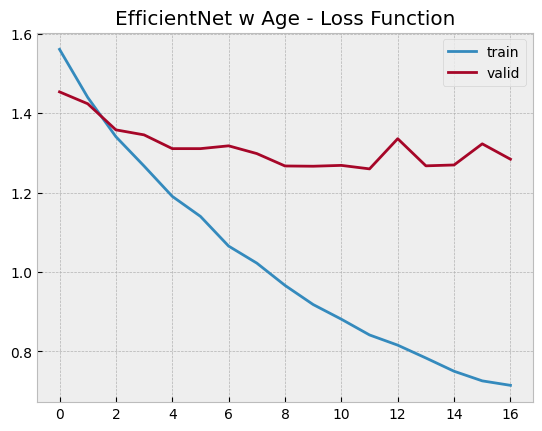

In [25]:
plt.style.use("bmh")

# Plot loss function value through epochs
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'valid')

plt.legend(loc='upper right')
plt.title('EfficientNet w Age - Loss Function')
plt.show()

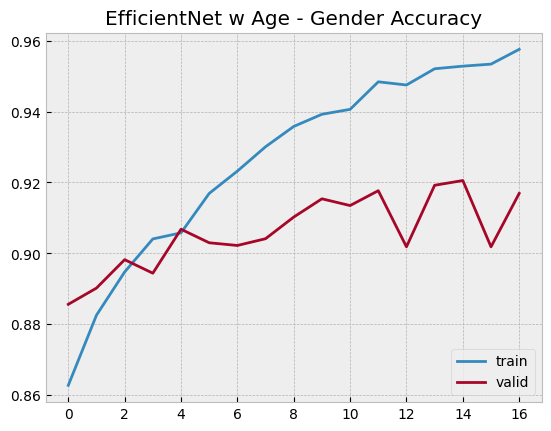

In [30]:
# Plot accuracy through epochs

plt.plot(history.history["gender_accuracy"], label = 'train')
plt.plot(history.history["val_gender_accuracy"], label = 'valid')

plt.legend(loc='lower right')
plt.title('EfficientNet w Age - Gender Accuracy')
plt.show()

In [36]:
test_loss, test_acc = our_model.evaluate(test_images, y_test, verbose=2)
print(test_acc)

164/164 - 16s - loss: 1.2841 - gender_loss: 0.2558 - age_loss: 1.0283 - gender_accuracy: 0.9169


ValueError: too many values to unpack (expected 2)

# Merge Output

In [37]:
merge_age = True

if merge_age:
    merge_age_choice = 'merge_output'
    assert merge_age_choice in ['merge_feature', 'merge_output']


In [38]:
# Freeze the pre-trained weights initially to train the added layers first
model.trainable = False 

model_out = model.output

# Adding custom Layers: age prediction
x_age = GlobalAveragePooling2D()(model_out)
x_age = Dense(512, activation="relu")(x_age)
x_age = Dropout(drop_out_rate)(x_age)
x_age_feat = Dense(512, activation="relu")(x_age)
#
num_classes = len(age_mapping_dict.keys())
age_predictions = Dense(num_classes, activation="softmax", name='age')(x_age_feat)

# Adding custom Layers: gender prediction: binary classification
x = GlobalAveragePooling2D()(model_out)
x = Dense(512, activation="relu")(x)
x = Dropout(drop_out_rate)(x)
x = Dense(512, activation="relu")(x)

# merge age predictions
assert merge_age_choice in ['merge_feature', 'merge_output']

if merge_age_choice == 'merge_feature':
    x = tf.keras.layers.Concatenate()([x_age_feat, x])
elif merge_age_choice == 'merge_output':
    x = tf.keras.layers.Concatenate()([age_predictions, x])

gender_predictions = Dense(1, activation="sigmoid", name='gender')(x)

# combine the result
predictions = [gender_predictions, age_predictions]

In [43]:
# creating the final model 
our_model_o = Model(inputs=model.input, outputs=predictions)
our_model_o.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 227, 227, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 227, 227, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 229, 229, 3)  0           normalization[0][0]              
____________________________________________________________________________________________

In [46]:
if merge_age:
    _loss = {'gender': 'binary_crossentropy', 
             'age': 'sparse_categorical_crossentropy'}
    _metrics = {'gender': 'accuracy'} # only uses gender acc as metrics
else:
    _loss='binary_crossentropy'
    _metrics = 'accuracy'

our_model_o.compile(optimizer=Adam(adam),
              loss=_loss,
              metrics=_metrics)

In [47]:
def get_call_backs():
    lrd = ReduceLROnPlateau(monitor = 'val_loss',
                            patience = patience,
                            verbose = verbose ,
                            factor = factor,
                            min_lr = min_lr)

    mcp = ModelCheckpoint('age_model_o.h5')

    es = EarlyStopping(verbose=verbose, patience=patience)
    
    return [lrd, mcp, es]

In [48]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# training
if merge_age:
    y_train = {'gender': y_train['gender'], 'age': y_train['age']}
    # test
    y_test = {'gender':y_test['gender'], 'age': y_test['age']}

history_o = our_model_o.fit(
    train_images, y_train, 
    batch_size=batch_size, 
    epochs=epochs, 
    validation_data=(test_images, y_test), 
    callbacks=get_call_backs())

2022-11-11 11:33:12.116302: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1888434792 exceeds 10% of free system memory.


Epoch 1/20
382/382 [==============================] - 60s 142ms/step - loss: 2.0158 - gender_loss: 0.4152 - age_loss: 1.6006 - gender_accuracy: 0.8031 - val_loss: 1.5445 - val_gender_loss: 0.3079 - val_age_loss: 1.2366 - val_gender_accuracy: 0.8640
Epoch 2/20
382/382 [==============================] - 54s 141ms/step - loss: 1.5772 - gender_loss: 0.3095 - age_loss: 1.2677 - gender_accuracy: 0.8696 - val_loss: 1.4835 - val_gender_loss: 0.2781 - val_age_loss: 1.2055 - val_gender_accuracy: 0.8831
Epoch 3/20
382/382 [==============================] - 54s 143ms/step - loss: 1.4439 - gender_loss: 0.2772 - age_loss: 1.1666 - gender_accuracy: 0.8785 - val_loss: 1.3963 - val_gender_loss: 0.2626 - val_age_loss: 1.1337 - val_gender_accuracy: 0.8877
Epoch 4/20
382/382 [==============================] - 55s 143ms/step - loss: 1.3515 - gender_loss: 0.2532 - age_loss: 1.0983 - gender_accuracy: 0.8936 - val_loss: 1.3855 - val_gender_loss: 0.2643 - val_age_loss: 1.1212 - val_gender_accuracy: 0.8902
Epoc

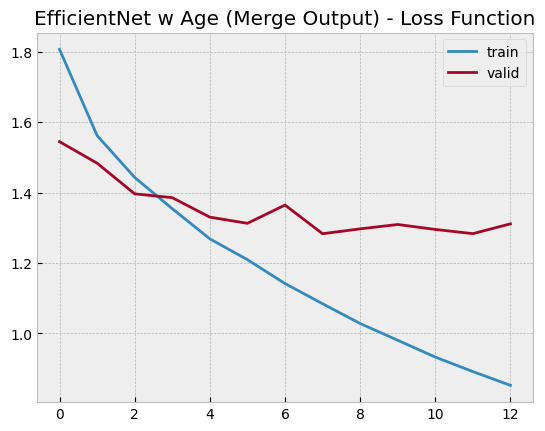

In [49]:
plt.style.use("bmh")

# Plot loss function value through epochs
plt.plot(history_o.history['loss'], label = 'train')
plt.plot(history_o.history['val_loss'], label = 'valid')

plt.legend(loc='upper right')
plt.title('EfficientNet w Age (Merge Output) - Loss Function')
plt.show()

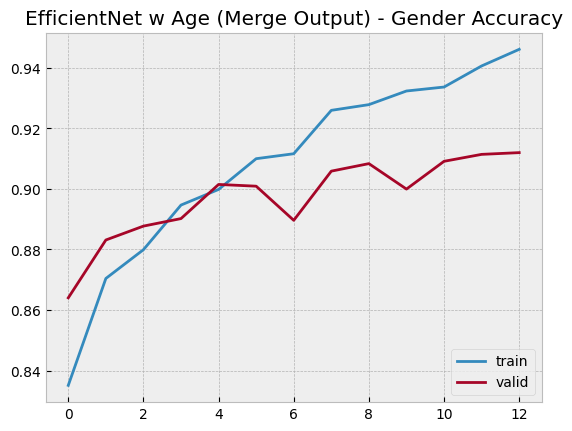

In [50]:
# Plot accuracy through epochs

plt.plot(history_o.history["gender_accuracy"], label = 'train')
plt.plot(history_o.history["val_gender_accuracy"], label = 'valid')

plt.legend(loc='lower right')
plt.title('EfficientNet w Age (Merge Output) - Gender Accuracy')
plt.show()

In [51]:
test_loss, test_acc = our_model_o.evaluate(test_images, y_test, verbose=2)
print(test_acc)

164/164 - 16s - loss: 1.3112 - gender_loss: 0.2563 - age_loss: 1.0548 - gender_accuracy: 0.9120


ValueError: too many values to unpack (expected 2)